# Fine-Grained Classification of birds

### 1) The Approach

- All the experiments were run locally for five epochs to verify code correctness. Once validated, training was scaled up using Colab Pro+ resulting in efficient utilization of compute units, enabling full model training.

- The data zip file was unzipped and then uploaded to the drive.

  #### Experimentation Phase
  - Since transfer learning was recommended, the first step was selecting an appropriate base model for fine-grained classification. Two architectures (Resnet50, EfficientNetB4) were tested with Adam optimizer.

  - As the first base model, ResNet50 (ImageNet weights, all layers trainable): Initial training (20 epochs) led to overfitting with a massive difference between training accuracy and validation accuracy (more than 40%). Adding batch normalization and dropout did not resolve the issue.
  - Then EfficientNetB4(ImageNet weights, all layers trainable) provided much lesser overfitting(~30).
  
  #### Implementation Phase
   - Since EfficientNetB4 provided better results but with some overfitting, it was chosen as the final base model. To handle the overfitting, the following techniques were implemented:

    - Phase 1:
      - Learning rate, Dropout rate were selected for Hyperparameter Tuning and 10 trails of random search with 15 epochs per each trail was run with frozen base model.

    - Phase 2:
      - With the best hyperparameters identified in Phase 1, the classifier head (newly added dense and dropout layers) was trained while keeping the EfficientNetB4 base model fully frozen. This phase focused on adapting the top layers to the dataset-specific features without modifying the pre-trained weights.

    - Phase 3:
      - To further refine feature extraction, the last 20 layers of the base model were unfrozen, allowing higher-level features to adapt to the target dataset.
      - The model was recompiled with a reduced learning rate (1/10th of the Phase 1 optimal rate) to avoid destabilizing pre-trained weights during fine-tuning.
      - Training resumed for an additional 5 epochs, maintaining the same early stopping and learning rate reduction.
      - This phase reduced overfitting significantly compared to training the entire base model from scratch. Validation loss remained stable, and the accuracy gap between training and validation datasets narrowed, indicating better generalization.

- All these techniques resulted in a model that achieved a balance between high accuracy and relatively low overfitting(93% training accuracy and 76% validation accuracy). The final model was able to generalize well to the validation set, demonstrating the effectiveness of the approach.

### 2) Metrics Used
- The below metrics were used to evaluate the final model.
 - Validation Accuracy
 - Test Accuracy
 - Precision(True Positives / (True Positive + False Positives))
 - Recall (True Positives / (True Positives + False Negatives))
 - F1-score (Harmonic mean of precision and recall)
 - Confusion Matrix
- Please refer the second last cell for the scores and confusion matrix of the best model on test set.


### 3) Improvement of performance and future scope
- Although the model provided a modest performance with good generalization there is still room for improvement. This can be achieved through the following methods:
  -  In our model we have just used limited values for tuning learning rate and dropout rate. Performance will improve if we add more values to the search grid and also add weight decay and optimizer choice to the hyperparameters.
  - Use of advance techniques(e.g. Focal Loss) to correct class imbalance.
  - Adoption of larger pre-trained architectures(e.g., EfficientNetV2-L or Vision Transformers) for transfer learning.
  - Using Stochastic Depth to decrease overfitting.



---



In [ ]:
%pip install pandas numpy scikit-learn keras-tuner matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 7.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Importing required packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras_tuner import RandomSearch
import keras_tuner as kt
import random
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

# The below variable will be used to set random seed for reproducibility
myStudentNumber = 230164781

random.seed(myStudentNumber)
np.random.seed(myStudentNumber)
tf.random.set_seed(myStudentNumber)

In [ ]:
# Defining data augmentation pipeline which will be used only on the training set
dataAugmentation2 = tf.keras.Sequential([
    layers.RandomFlip("horizontal", seed=myStudentNumber),
    layers.RandomRotation(0.1,seed=myStudentNumber),
    layers.RandomZoom(0.1,seed=myStudentNumber),
    layers.RandomContrast(0.1,seed=myStudentNumber),
])


dataPath = '/content/drive/MyDrive/task2/CUB_200_2011/images'
imgSize = (224, 224)
batchSize = 32


# Training set (90%)
train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataPath,
    validation_split=0.1,
    subset="training",
    seed=myStudentNumber,
    image_size=imgSize,
    batch_size=batchSize
)

# Temp set (10% to split into val/test)
temp_dataset = tf.keras.utils.image_dataset_from_directory(
    dataPath,
    validation_split=0.1,
    subset="validation",
    seed=myStudentNumber,
    image_size=imgSize,
    batch_size=batchSize
)


# Splitting temp_dataset into val (50% of 10% = 5%) and test (50% of 10% = 5%)
valSize = int(0.5 * len(temp_dataset))
val_dataset = temp_dataset.take(valSize)
test_dataset = temp_dataset.skip(valSize)

# Applying data augmentation only to the training set
train_dataset = train_dataset.map(lambda x, y: (dataAugmentation2(x, training=True), y))


Found 11788 files belonging to 200 classes.
Using 10610 files for training.
Found 11788 files belonging to 200 classes.
Using 1178 files for validation.


In [ ]:
"""
Try 1:
"""

def createModel():
    baseModel= ResNet50(weights='imagenet', include_top=False, input_shape=(imgSize[0], imgSize[1], 3))
    baseModel.trainable = True


    model = models.Sequential([
        baseModel,
        layers.GlobalAveragePooling2D(),
        layers.Dense(200, activation='softmax')
    ])



    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model



model=createModel()

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
)

model.save('firstDraftTwentyEpochs.keras')


Epoch 1/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 966s 3s/step - accuracy: 0.0151 - loss: 5.3622 - val_accuracy: 0.0127 - val_loss: 8.7749
Epoch 2/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 122s 413ms/step - accuracy: 0.0583 - loss: 4.4134 - val_accuracy: 0.0380 - val_loss: 6.1910
Epoch 3/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 115s 389ms/step - accuracy: 0.1210 - loss: 3.7503 - val_accuracy: 0.1047 - val_loss: 3.9948
Epoch 4/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 113s 383ms/step - accuracy: 0.2101 - loss: 3.1876 - val_accuracy: 0.1816 - val_loss: 3.5099
Epoch 5/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 113s 382ms/step - accuracy: 0.2916 - loss: 2.7410 - val_accuracy: 0.1782 - val_loss: 3.7271
Epoch 6/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 112s 378ms/step - accuracy: 0.3774 - loss: 2.3577 - val_accuracy: 0.1850 - val_loss: 3.5086
Epoch 7/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 112s 380ms/step - accuracy: 0.4524 - loss: 2.0359 - val_accuracy: 0.3142 - val_loss: 2.9845
Epoch 8/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 112s 381ms/step - accuracy: 0.5096 - lo

In [ ]:
"""
Try 2:
"""

def createModel():
    baseModel= ResNet50(weights='imagenet', include_top=False, input_shape=(imgSize[0], imgSize[1], 3))
    baseModel.trainable = True


    model = models.Sequential([
        baseModel,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(200, activation='softmax')
    ])



    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model



model=createModel()

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
)

model.save('secondDraftTwentyEpochs.keras')


Epoch 1/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 190s 455ms/step - accuracy: 0.0088 - loss: 6.2617 - val_accuracy: 0.0059 - val_loss: 9725.7969
Epoch 2/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 111s 374ms/step - accuracy: 0.0103 - loss: 6.5040 - val_accuracy: 0.0093 - val_loss: 201.7600
Epoch 3/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 110s 373ms/step - accuracy: 0.0095 - loss: 6.2803 - val_accuracy: 0.0034 - val_loss: 225.4001
Epoch 4/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 110s 373ms/step - accuracy: 0.0157 - loss: 5.8419 - val_accuracy: 0.0169 - val_loss: 5.5878
Epoch 5/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 110s 372ms/step - accuracy: 0.0259 - loss: 5.5672 - val_accuracy: 0.0236 - val_loss: 6.1605
Epoch 6/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 110s 373ms/step - accuracy: 0.0306 - loss: 5.3933 - val_accuracy: 0.0296 - val_loss: 59.6163
Epoch 7/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 110s 372ms/step - accuracy: 0.0412 - loss: 5.1448 - val_accuracy: 0.0422 - val_loss: 11.7334
Epoch 8/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 110s 372ms/step - accuracy:

In [ ]:
"""
Try 3
"""

def createModel():
    # Load the EfficientNetB4 model without the top classifier layers.
    baseModel = tf.keras.applications.EfficientNetB4(
        weights='imagenet',
        include_top=False,
        input_shape=(imgSize[0], imgSize[1], 3)
    )

    # Freeze most layers in the base model except the last 20 layers.
    for layer in baseModel.layers[:-20]:
        layer.trainable = False
    for layer in baseModel.layers[-20:]:
        layer.trainable = True

    # Create a new model on top of the base model.
    model = tf.keras.models.Sequential([
        baseModel,
        tf.keras.layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        tf.keras.layers.Dense(200, activation='softmax')
    ])

    # Compile the model.
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Create and train the model.
model = createModel()

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
)


Epoch 1/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 202s 473ms/step - accuracy: 0.3485 - loss: 3.0925 - val_accuracy: 0.6181 - val_loss: 1.4441
Epoch 2/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 125s 377ms/step - accuracy: 0.6984 - loss: 1.1154 - val_accuracy: 0.6146 - val_loss: 1.5996
Epoch 3/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 126s 378ms/step - accuracy: 0.7813 - loss: 0.7395 - val_accuracy: 0.6493 - val_loss: 1.5162
Epoch 4/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 126s 378ms/step - accuracy: 0.8410 - loss: 0.5097 - val_accuracy: 0.6944 - val_loss: 1.3851
Epoch 5/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 125s 377ms/step - accuracy: 0.8714 - loss: 0.4063 - val_accuracy: 0.6910 - val_loss: 1.4464
Epoch 6/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 124s 374ms/step - accuracy: 0.9018 - loss: 0.3267 - val_accuracy: 0.6858 - val_loss: 1.5156
Epoch 7/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 125s 375ms/step - accuracy: 0.9044 - loss: 0.2966 - val_accuracy: 0.6615 - val_loss: 1.6257
Epoch 8/20
332/332 ━━━━━━━━━━━━━━━━━━━━ 125s 375ms/step - accuracy: 0.9064 -

In [ ]:
model.save("try3.keras")

In [ ]:
"""
Try 4
"""

# Defining image size and number of classes
imgSize = (224, 224)
batchSize = 32
num_classes = 200

# Defining Hypermodel definition for Keras Tuner
def build_model(hp):
    # dropout rate and learning rate are the selected hyperparameters for tuning
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')

    # Loading the EfficientNetB4 model without the top layers
    base_model = tf.keras.applications.EfficientNetB4(
        weights='imagenet',
        include_top=False,
        input_shape=(imgSize[0], imgSize[1], 3)
    )
    # Initially freezing the entire base model
    base_model.trainable = False

    # Creating the model and including dropout
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compiling the model with the tuned learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Phase 1: Running 10 trails and 15 epochs per trail to find the best hyperparameters
# Hyperparameter Tuning
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='efficientnet_tuning'
)

# Running the hyperparameter search
tuner.search(
    train_dataset,
    validation_data=val_dataset,
    epochs=15,
    callbacks=[
        callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
    ]
)

# Getting the best hyperparameters and building the model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)


# Phase 2: Training only the new top layers
initial_epochs = 5
print("Training classifier head only...")
history1 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=initial_epochs,
    callbacks=[
        callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
    ]
)

# Phase 3:  Gradual Unfreezing: Fine-tuning
# Unfreezing the last 20 layers of the base model for fine-tuning
base_model = model.layers[0]
for layer in base_model.layers[:-20]:
    layer.trainable = False
for layer in base_model.layers[-20:]:
    layer.trainable = True


# Recompiling the model with a lower learning rate for fine-tuning
fine_tune_lr = best_hps.get('learning_rate') / 10
model.compile(
    optimizer=tf.keras.optimizers.Adam(fine_tune_lr),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

fine_tune_epochs = 5
total_epochs = initial_epochs + fine_tune_epochs
print("Fine-tuning with gradual unfreezing...")
history2 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=total_epochs,
    initial_epoch=history1.epoch[-1] + 1,
    callbacks=[
        callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
    ]
)


Trial 10 Complete [00h 32m 14s]
val_accuracy: 0.7118055820465088

Best val_accuracy So Far: 0.7274305820465088
Total elapsed time: 04h 58m 21s
Training classifier head only...
Epoch 1/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 186s 452ms/step - accuracy: 0.2123 - loss: 3.9977 - val_accuracy: 0.5764 - val_loss: 1.8339 - learning_rate: 0.0012
Epoch 2/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 124s 372ms/step - accuracy: 0.6007 - loss: 1.6760 - val_accuracy: 0.6354 - val_loss: 1.4241 - learning_rate: 0.0012
Epoch 3/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 124s 372ms/step - accuracy: 0.6845 - loss: 1.2734 - val_accuracy: 0.6684 - val_loss: 1.2422 - learning_rate: 0.0012
Epoch 4/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 124s 372ms/step - accuracy: 0.7298 - loss: 1.0566 - val_accuracy: 0.6788 - val_loss: 1.2064 - learning_rate: 0.0012
Epoch 5/5
332/332 ━━━━━━━━━━━━━━━━━━━━ 124s 373ms/step - accuracy: 0.7620 - loss: 0.9465 - val_accuracy: 0.6840 - val_loss: 1.1173 - learning_rate: 0.0012
Fine-tuning with gradual unfreezing...
Epoch 6/10

In [ ]:
model.save('t2bestOneYet.keras')

tf.keras.models.load_model('t2bestOneYet.keras')

<Sequential name=sequential_1, built=True>

In [ ]:
"""
Running phase 3 for another 10 epochs in hopes of improving the validation accuracy
"""

# Load the saved model
model = tf.keras.models.load_model('/content/drive/MyDrive/t2bestOneYet.keras')

# Retrieving the base model
base_model = model.layers[0]

# Unfreezing the last 20 layers for fine-tuning as before
for layer in base_model.layers[:-20]:
    layer.trainable = False
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Not sure if the model has saved the learning rate, so exception handling is written
try:
    best_lr = best_hps.get('learning_rate')
except NameError:

    best_lr = 0.0012

fine_tune_lr = best_lr / 10

# Recompiling the model with the reduced learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tune_lr),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine tuning the model for 10 additional epochs
history = model.fit(
    train_dataset,           # Ensure these datasets are defined
    validation_data=val_dataset,
    epochs=10,
    callbacks=[
        callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
    ]
)


Epoch 1/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 402s 1s/step - accuracy: 0.9093 - loss: 0.3567 - val_accuracy: 0.7396 - val_loss: 0.8952 - learning_rate: 1.2000e-04
Epoch 2/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 128s 384ms/step - accuracy: 0.9190 - loss: 0.3196 - val_accuracy: 0.7535 - val_loss: 0.9041 - learning_rate: 1.2000e-04
Epoch 3/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 126s 378ms/step - accuracy: 0.9300 - loss: 0.2796 - val_accuracy: 0.7604 - val_loss: 0.9124 - learning_rate: 1.2000e-04
Epoch 4/10
332/332 ━━━━━━━━━━━━━━━━━━━━ 126s 379ms/step - accuracy: 0.9454 - loss: 0.2382 - val_accuracy: 0.7361 - val_loss: 0.9632 - learning_rate: 6.0000e-05


In [ ]:
model.save('/content/drive/MyDrive/t2bestOneYet.keras')


In [ ]:
model = load_model('/content/drive/MyDrive/t2bestOneYet.keras')

In [ ]:
preds = None
labels = None
for x,y in test_dataset:
  if preds is None:
    preds = model.predict(x)
    labels = np.array(y.numpy())
  preds = np.concatenate([preds, model.predict(x)])
  labels = np.append(labels, y)

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


In [ ]:
model.evaluate(test_dataset)

19/19 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.7321 - loss: 0.9185


[0.9354708194732666, 0.724252462387085]

              precision    recall  f1-score   support

           0     1.0000    0.6667    0.8000         3
           1     0.8333    0.8333    0.8333         6
           2     0.3333    1.0000    0.5000         1
           3     1.0000    1.0000    1.0000         3
           4     1.0000    1.0000    1.0000         4
           7     0.6667    1.0000    0.8000         2
           8     0.7500    0.5000    0.6000         6
          10     0.0000    0.0000    0.0000         2
          11     1.0000    1.0000    1.0000         3
          12     1.0000    0.5000    0.6667         2
          13     0.5000    1.0000    0.6667         1
          14     0.7500    1.0000    0.8571         3
          15     1.0000    0.6667    0.8000         3
          16     1.0000    1.0000    1.0000         5
          17     1.0000    1.0000    1.0000         2
          18     0.8333    1.0000    0.9091         5
          19     1.0000    0.6667    0.8000         6
          20     1.0000    

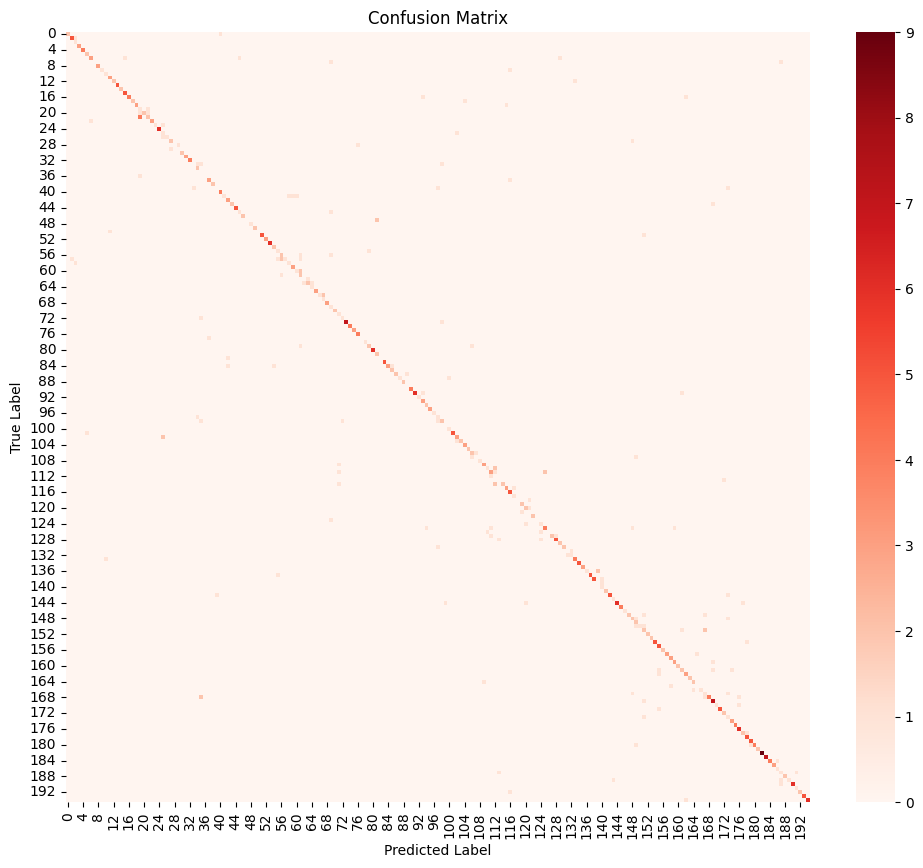

In [ ]:
# Classification report
print(classification_report(labels, np.argmax(preds, axis=1), digits=4, zero_division=0))

# Confusion Matrix
conf_matrix = confusion_matrix(labels, np.argmax(preds, axis = 1))
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=False, fmt='d', cmap='Reds')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

---
# Demo

In [ ]:
# Loading class names from the provided file
class_file = '/content/drive/MyDrive/task2/CUB_200_2011/classes.txt'
model = load_model("/content/drive/MyDrive/t2bestOneYet.keras")
with open(class_file, 'r') as f:
    class_names = [line.strip().split('.', 1)[1].replace('_', ' ') for line in f]

# Defining the parameters
img_size = (224, 224)
batch_size = 32
demo_folder = '/content/demo'


demo_dataset = tf.keras.utils.image_dataset_from_directory(
    demo_folder,
    labels=None,
    label_mode=None,
    color_mode='rgb',
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False
)

# Getting ordered file paths and predict
file_paths = demo_dataset.file_paths
predictions = model.predict(demo_dataset)
predicted_classes = np.argmax(predictions, axis=1)
confidence_scores = np.max(predictions, axis=1)

# Displaying formatted results
print("\nPREDICTION RESULTS:")
print("=" * 80)
for file_path, class_idx, confidence in zip(file_paths, predicted_classes, confidence_scores):
    class_name = class_names[class_idx]
    file_name = os.path.basename(file_path)

    print(f"Image: {file_name}")
    print(f"Predicted: {class_name}")
    print(f"Confidence: {confidence:.2%}")
    print("-" * 60)



Found 5 files.
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step

PREDICTION RESULTS:
Image: Eopsaltria_australis_-_Mogo_Campground.jpg
Predicted: Tropical Kingbird
Confidence: 42.00%
------------------------------------------------------------
Image: Louisiana_Waterthrush_0025_177403.jpg
Predicted: Louisiana Waterthrush
Confidence: 81.74%
------------------------------------------------------------
Image: Northern_Fulmar_0037_43712.jpg
Predicted: Northern Fulmar
Confidence: 97.39%
------------------------------------------------------------
Image: Rock_Wren_0073_188952.jpg
Predicted: Rock Wren
Confidence: 97.10%
------------------------------------------------------------
Image: Ruby_Throated_Hummingbird_0013_57212.jpg
Predicted: Ruby throated Hummingbird
Confidence: 97.08%
------------------------------------------------------------
